In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 kaggle.json
!kaggle datasets download -d oddrationale/mnist-in-csv
! unzip mnist-in-csv.zip -d mnist

 98% 15.0M/15.2M [00:00<00:00, 50.7MB/s]
100% 15.2M/15.2M [00:00<00:00, 44.7MB/s]
Archive:  mnist-in-csv.zip
  inflating: mnist/mnist_test.csv    
  inflating: mnist/mnist_train.csv   


In [ ]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.optim as opt
import torch.nn.functional as af
import os
import numpy as np
import pandas as pd
import cv2
from torch.utils.data import Dataset
import PIL
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.manifold import TSNE
from google.colab import files
from matplotlib import pyplot as plt
import math

In [ ]:
train_ = pd.read_csv('/content/mnist/mnist_train.csv')

def split_train(df, val_per):
  val_size = int(df.shape[0]*val_per)

  train = df.iloc[:df.shape[0]-val_size,:]
  val = df.iloc[df.shape[0]-val_size:,:]
  train.to_csv('train.csv',index=False)
  val.to_csv('val.csv',index=False)

split_train(train_,0.15)

In [ ]:
print(pd.read_csv('train.csv').describe())
print(pd.read_csv('val.csv').describe())


In [ ]:
class ConvDw(nn.Module):
  def __init__(self, input_dim, output_dim,stride):
    super(ConvDw,self).__init__()
    self.convdw = nn.Conv2d(input_dim,input_dim,3,stride,1,groups=input_dim)
    self.bn_dw = nn.BatchNorm2d(input_dim)
    self.relu_dw = nn.ReLU()
    self.convpw = nn.Conv2d(input_dim, output_dim, 1, 1,0)
    self.bn_pw = nn.BatchNorm2d(output_dim)
    self.relu_pw = nn.ReLU()


  def forward(self, x):
    x = self.convdw(x)
    x = self.bn_dw(x)
    x = self.relu_dw(x)
    x = self.convpw(x)
    x = self.bn_pw(x)
    x = self.relu_pw(x)
    return x


In [ ]:
from torchvision.transforms.transforms import Resize
class CustomDataloader(Dataset):
  def __init__(self, csv_file, img_dir, transform=None):
    self.imgs_labels = pd.read_csv(csv_file)
    self.img_dir = img_dir
    self.transform = transform

  def __len__(self):
    return len(self.imgs_labels)

  def __getitem__(self,idx):

    img = self.imgs_labels.iloc[idx,1:]
    img = img.to_numpy().flatten().reshape(28,28)
    img = PIL.Image.fromarray((img * 255).astype(np.uint8))
    
    labels = torch.tensor(self.imgs_labels.iloc[idx,0])

    if self.transform:
      img = self.transform(img)

    return (img,labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
                              transforms.Grayscale(),
                              transforms.Resize((28,28)),
                              transforms.ToTensor(),
                              transforms.Normalize(0,0.5)])



In [ ]:
train_path = "train.csv"
test_path = "/content/mnist/mnist_test.csv"
val_path = "val.csv"
batch_size = 256
train_dataset = CustomDataloader(train_path, "./",transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CustomDataloader(test_path, "./",transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

val_dataset = CustomDataloader(val_path, "./",transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)



In [ ]:




class CNN_Mobile_Net(nn.Module):

  def __init__(self, conv_block_count, mobilenet_block_count,input_dim, num_classes):
    super(CNN_Mobile_Net,self).__init__()
    conv_channels = [2**(i+4) for i in range(conv_block_count)]
    conv_channels.insert(0,input_dim[0])
    print(conv_channels)
    self.conv = nn.ModuleList([nn.Conv2d(in_ch, out_ch, 3,1,1) for in_ch, out_ch in zip(conv_channels,conv_channels[1:])])
    # self.conv = nn.Conv2d(input_dim[0], 32, 3,1,1)
    channels = [int(2**(i+math.log2(conv_channels[-1]))) for i in range(1,mobilenet_block_count)]
    
    channels.insert(0, conv_channels[-1])
    print(channels)
    self.mob = nn.ModuleList([ConvDw(input_dim=in_ch,output_dim=out_ch,stride=1) for in_ch,out_ch in zip(channels,channels[1:])])

    self.avgpooling = nn.AdaptiveAvgPool2d((1,1))

    self.fc = nn.Linear(self._get_conv_output(input_dim),num_classes)

  def convolution(self,x):
    # x_convs = self.conv[0](Variable(torch.from_numpy(X).type(torch.FloatTensor)))
    if len(self.conv) >= 1:
      for conv in self.conv:
        x = conv(x)

    if len(self.mob) >= 1:
      for mobconv in self.mob:
          x = mobconv(x)
    return x

  def forward(self,x):
    x = self.convolution(x)
    x = self.avgpooling(x)
    x = x.view(x.size(0),-1)
    x = self.fc(x)
    return x

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self.avgpooling(self.convolution(input))

    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size

  def save_model(self, path):
    torch.save(self.state_dict(),path)

  def load_model(self, path):
    self.load_state_dict(torch.load(path))
    
  def train(self, train_loader, val_loader, optimizer, criterion, epochs):
    
    train_loss = []
    val_loss=[]
    train_accuracy=[]
    val_accuracy=[]

    for epoch in range(epochs):

      t_loader = tqdm(train_loader)

      epoch_loss_train=0
      batch_acc_train = 0
      correct_train = 0
      l = 0
      for batch, (imgs,labels) in enumerate(t_loader):
        imgs = imgs.to(device=device)

        labels = labels.to(device=device)

        pred = self.forward(imgs)
        pred = torch.squeeze(pred)
        loss = criterion(pred,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # loss and accuracy

        epoch_loss_train+=loss.item()
        # print(pred.argmax(1))
        # print(labels)
        # print()
        # break
        correct_train += ((pred.detach().argmax(1).to(device='cpu').numpy() == labels.to(device='cpu').numpy()).sum())
        t_loader.set_description(f"Training {epoch+1}/{epochs}")
        t_loader.set_postfix(loss=loss.item())
        l+=labels.size(0)


      train_acc = correct_train/l
      train_los = epoch_loss_train/l
      print(f"\n acc = {train_acc}, loss = {train_los}")
      train_loss.append(train_los)
      train_accuracy.append(train_acc)

      
      with torch.no_grad():
        v_loader = tqdm(val_loader)

        epoch_loss_val=0
        batch_acc_val = 0
        correct_val = 0
        l = 0
        for batch, (imgs,labels) in enumerate(v_loader):
          imgs = imgs.to(device=device)
          labels = labels.to(device=device)
          pred = self.forward(imgs)
          pred = torch.squeeze(pred)
          loss = criterion(pred,labels)
          # loss and accuracy
          epoch_loss_val+=loss.item()
          correct_val += ((pred.detach().argmax(1).to(device='cpu').numpy() == labels.to(device='cpu').numpy()).sum())

          # correct_val += ((pred.argmax(1) == labels.to(device='cpu').numpy()).sum())
          v_loader.set_description(f"Validation {epoch+1}/{epochs}")
          v_loader.set_postfix(loss=loss.item())
          l+=labels.size(0)


        val_acc = correct_val/l
        val_los = epoch_loss_val/l
        print(f"\n acc = {val_acc}, loss = {val_los}")
        val_loss.append(val_los)
        val_accuracy.append(val_acc)

    return self,train_loss,val_loss,train_accuracy,val_accuracy




In [ ]:
cnn = CNN_Mobile_Net(2,3,(1,28,28),10)
cnn.to(device)

learning_rate = 0.1
epochs = 30
criterion = nn.CrossEntropyLoss()

optimizer = opt.Adam(cnn.parameters(),lr=learning_rate,amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience = 1)

net,train_loss,val_loss,train_accuracy,val_accuracy = cnn.train(train_loader,
                                                                val_loader,optimizer,
                                                                criterion,epochs=epochs)


[1, 16, 32]
[32, 64, 128]


Training 1/30: 100%|██████████| 200/200 [00:39<00:00,  5.07it/s, loss=0.458]



 acc = 0.42376470588235293, loss = 0.006301361948836084


Validation 1/30: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s, loss=0.595]



 acc = 0.7787777777777778, loss = 0.002623243232568105


Training 2/30: 100%|██████████| 200/200 [00:40<00:00,  5.00it/s, loss=0.264]



 acc = 0.8620196078431372, loss = 0.0017245029725280463


Validation 2/30: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s, loss=0.248]



 acc = 0.9052222222222223, loss = 0.0012338646252950032


Training 3/30: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s, loss=0.361]



 acc = 0.9105098039215687, loss = 0.001124390104822084


Validation 3/30: 100%|██████████| 36/36 [00:05<00:00,  6.09it/s, loss=0.225]



 acc = 0.9275555555555556, loss = 0.0009213336457808812


Training 4/30: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s, loss=0.143]



 acc = 0.9253529411764706, loss = 0.0009267232555384729


Validation 4/30: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s, loss=0.394]



 acc = 0.9262222222222222, loss = 0.0009436109479930665


Training 5/30: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s, loss=0.295]



 acc = 0.936156862745098, loss = 0.0008016265300559062


Validation 5/30: 100%|██████████| 36/36 [00:05<00:00,  6.06it/s, loss=0.246]



 acc = 0.9492222222222222, loss = 0.0006515483740303251


Training 6/30: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s, loss=0.169]



 acc = 0.9434313725490197, loss = 0.0007270200968373055


Validation 6/30: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s, loss=0.0506]



 acc = 0.954, loss = 0.0005927620083093643


Training 7/30: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.119]



 acc = 0.9418823529411765, loss = 0.0007324931326450087


Validation 7/30: 100%|██████████| 36/36 [00:05<00:00,  6.13it/s, loss=0.0773]



 acc = 0.9592222222222222, loss = 0.0005559153126345741


Training 8/30: 100%|██████████| 200/200 [00:38<00:00,  5.21it/s, loss=0.224]



 acc = 0.9482352941176471, loss = 0.0006507424013871772


Validation 8/30: 100%|██████████| 36/36 [00:05<00:00,  6.10it/s, loss=0.239]



 acc = 0.954, loss = 0.000594737086031172


Training 9/30: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s, loss=0.0624]



 acc = 0.9518823529411765, loss = 0.0006189746250416718


Validation 9/30: 100%|██████████| 36/36 [00:05<00:00,  6.12it/s, loss=0.239]



 acc = 0.9585555555555556, loss = 0.0005791156142950058


Training 10/30: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s, loss=0.202]



 acc = 0.9506862745098039, loss = 0.0006180390762347801


Validation 10/30: 100%|██████████| 36/36 [00:05<00:00,  6.37it/s, loss=0.139]



 acc = 0.9548888888888889, loss = 0.0005891414880752564


Training 11/30: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.218]



 acc = 0.9552352941176471, loss = 0.0005712173831667386


Validation 11/30: 100%|██████████| 36/36 [00:05<00:00,  6.42it/s, loss=0.299]



 acc = 0.9605555555555556, loss = 0.0005313927572634485


Training 12/30: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.196]



 acc = 0.958078431372549, loss = 0.0005322232545883048


Validation 12/30: 100%|██████████| 36/36 [00:05<00:00,  6.36it/s, loss=0.334]



 acc = 0.9538888888888889, loss = 0.0006023506596684456


Training 13/30: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.0502]



 acc = 0.9572156862745098, loss = 0.0005400692215737175


Validation 13/30: 100%|██████████| 36/36 [00:05<00:00,  6.35it/s, loss=0.142]



 acc = 0.9648888888888889, loss = 0.00047189065607057675


Training 14/30: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s, loss=0.183]



 acc = 0.961078431372549, loss = 0.0004997486140505941


Validation 14/30: 100%|██████████| 36/36 [00:05<00:00,  6.28it/s, loss=0.0893]



 acc = 0.9671111111111111, loss = 0.00042731510351101557


Training 15/30: 100%|██████████| 200/200 [00:38<00:00,  5.19it/s, loss=0.119]



 acc = 0.9607254901960784, loss = 0.0004939172919474396


Validation 15/30: 100%|██████████| 36/36 [00:05<00:00,  6.29it/s, loss=0.1]



 acc = 0.9557777777777777, loss = 0.0005953870043158531


Training 16/30: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s, loss=0.158]



 acc = 0.9605882352941176, loss = 0.0004975873454674786


Validation 16/30: 100%|██████████| 36/36 [00:05<00:00,  6.25it/s, loss=0.0134]



 acc = 0.9615555555555556, loss = 0.0005024585715598531


Training 17/30: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s, loss=0.279]



 acc = 0.9626078431372549, loss = 0.0004797100429879684


Validation 17/30: 100%|██████████| 36/36 [00:05<00:00,  6.35it/s, loss=0.168]



 acc = 0.9666666666666667, loss = 0.0004516938312186135


Training 18/30: 100%|██████████| 200/200 [00:39<00:00,  5.08it/s, loss=0.327]



 acc = 0.9645882352941176, loss = 0.0004482573711988973


Validation 18/30: 100%|██████████| 36/36 [00:05<00:00,  6.24it/s, loss=0.0444]



 acc = 0.9638888888888889, loss = 0.0004762084194355541


Training 19/30: 100%|██████████| 200/200 [00:38<00:00,  5.20it/s, loss=0.0589]



 acc = 0.9647058823529412, loss = 0.00044806953190880665


Validation 19/30: 100%|██████████| 36/36 [00:05<00:00,  6.23it/s, loss=0.0401]



 acc = 0.9637777777777777, loss = 0.00045428165710634656


Training 20/30: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s, loss=0.0449]



 acc = 0.9643333333333334, loss = 0.0004367838588853677


Validation 20/30: 100%|██████████| 36/36 [00:05<00:00,  6.20it/s, loss=0.0686]



 acc = 0.9696666666666667, loss = 0.0004221563446852896


Training 21/30: 100%|██████████| 200/200 [00:38<00:00,  5.17it/s, loss=0.208]



 acc = 0.9650588235294117, loss = 0.0004318152788076915


Validation 21/30: 100%|██████████| 36/36 [00:05<00:00,  6.35it/s, loss=0.154]



 acc = 0.9671111111111111, loss = 0.00045407174569037225


Training 22/30: 100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.0698]



 acc = 0.9654705882352941, loss = 0.0004299323623086892


Validation 22/30: 100%|██████████| 36/36 [00:05<00:00,  6.49it/s, loss=0.202]



 acc = 0.9691111111111111, loss = 0.0004117301214072439


Training 23/30: 100%|██████████| 200/200 [00:37<00:00,  5.27it/s, loss=0.0485]



 acc = 0.9669411764705882, loss = 0.00041021511382332036


Validation 23/30: 100%|██████████| 36/36 [00:05<00:00,  6.48it/s, loss=0.391]



 acc = 0.9685555555555555, loss = 0.0004196300192011727


Training 24/30: 100%|██████████| 200/200 [00:38<00:00,  5.18it/s, loss=0.164]



 acc = 0.9674901960784313, loss = 0.00041075744852423667


Validation 24/30: 100%|██████████| 36/36 [00:05<00:00,  6.24it/s, loss=0.0394]



 acc = 0.967, loss = 0.000433364433546861


Training 25/30: 100%|██████████| 200/200 [00:39<00:00,  5.12it/s, loss=0.0873]



 acc = 0.9655294117647059, loss = 0.00043207259118264795


Validation 25/30: 100%|██████████| 36/36 [00:05<00:00,  6.33it/s, loss=0.228]



 acc = 0.964, loss = 0.0004859219826757908


Training 26/30: 100%|██████████| 200/200 [00:38<00:00,  5.22it/s, loss=0.0401]



 acc = 0.969156862745098, loss = 0.00038102624397359645


Validation 26/30: 100%|██████████| 36/36 [00:05<00:00,  6.32it/s, loss=0.0137]



 acc = 0.9648888888888889, loss = 0.0004518555589020252


Training 27/30: 100%|██████████| 200/200 [00:38<00:00,  5.14it/s, loss=0.255]



 acc = 0.9695294117647059, loss = 0.0003788311123555782


Validation 27/30: 100%|██████████| 36/36 [00:05<00:00,  6.30it/s, loss=0.236]



 acc = 0.9705555555555555, loss = 0.0003970576971769333


Training 28/30: 100%|██████████| 200/200 [00:38<00:00,  5.23it/s, loss=0.11]



 acc = 0.9680196078431372, loss = 0.00038931183933335194


Validation 28/30: 100%|██████████| 36/36 [00:05<00:00,  6.54it/s, loss=0.0958]



 acc = 0.9657777777777777, loss = 0.0004357733544376161


Training 29/30: 100%|██████████| 200/200 [00:38<00:00,  5.25it/s, loss=0.0818]



 acc = 0.968843137254902, loss = 0.00038841405762907335


Validation 29/30: 100%|██████████| 36/36 [00:05<00:00,  6.39it/s, loss=0.0324]



 acc = 0.9731111111111111, loss = 0.00033492723521259094


Training 30/30: 100%|██████████| 200/200 [00:37<00:00,  5.28it/s, loss=0.107]



 acc = 0.97, loss = 0.0003696691221831476


Validation 30/30: 100%|██████████| 36/36 [00:05<00:00,  6.38it/s, loss=0.225]


 acc = 0.9676666666666667, loss = 0.00042778642061683865


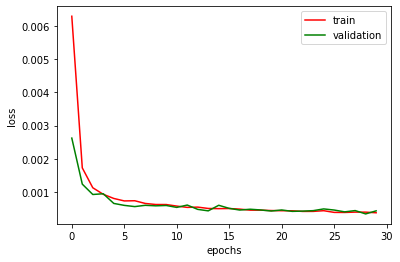

In [ ]:
ax = plt.figure()
plt.plot(np.array(train_loss),'r',label="train")
plt.plot(np.array(val_loss),'g',label="validation")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()



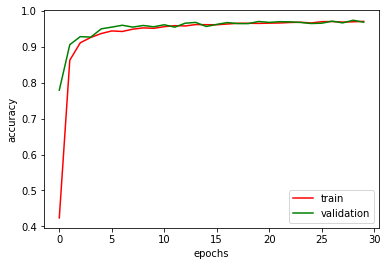

In [ ]:
plt.plot(np.array(train_accuracy),'r',label="train")
plt.plot(np.array(val_accuracy),'g',label="validation")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [ ]:

def test(test_loader,loss_func,batch_size,net):
  loader=tqdm(test_loader)
  ep_acc = 0
  accuracy = 0
  ep_loss = 0
  loss = 0
  n_dp=0
  correct = 0
  with torch.no_grad():  
    for batch, (imgs1,labels) in enumerate(loader):

      imgs1=imgs1.to(device)
      # imgs2=imgs2.to(device='cpu')

      labels=labels.to(device)

      pred = net.forward(imgs1)
      pred = torch.squeeze(pred)
      ep_loss += loss_func(pred,labels)
      correct += ((pred.detach().argmax(1).to(device='cpu').numpy() == labels.to(device='cpu').numpy()).sum())
      n_dp+=labels.size(0)

  # print(f"Accuracy: {accuracy/n_dp}, Loss: {loss/n_dp}")

  return correct/n_dp, ep_loss/n_dp
# net.to(device=device)
a,l = test(test_loader,criterion,256,cnn)

print(l.item())
print(a)

100%|██████████| 40/40 [00:07<00:00,  5.51it/s]

0.00037956846063025296
0.9732
